# Cell 1: 노트북 개요

## 07_evaluation.ipynb - CARLA 평가 및 시각화

이 노트북에서는 학습된 모델을 CARLA 환경에서 평가합니다.

### 평가 항목
1. **주행 성능**: Success Rate, Collision Rate, Lane Invasion Rate
2. **지침 준수율**: Traffic Light Compliance, Speed Limit Compliance
3. **효율성**: Average Speed, Route Completion Time

### 참고 논문
- **CARLA Benchmark** (Dosovitskiy et al., 2017): 자율주행 평가 프로토콜
- **NoCrash Benchmark** (Codevilla et al., 2019): 더 엄격한 평가 기준

In [1]:
# Cell 1: 라이브러리 및 설정

import sys
import os
import json
import time
import logging
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torchvision.transforms as T

# 프로젝트 루트
PROJECT_ROOT = Path().absolute().parent
sys.path.insert(0, str(PROJECT_ROOT))

# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# GPU 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# CARLA 임포트
try:
    import carla
    CARLA_AVAILABLE = True
    print("✅ CARLA 사용 가능")
except ImportError:
    CARLA_AVAILABLE = False
    print("⚠️ CARLA를 사용할 수 없습니다. 오프라인 분석만 가능합니다.")

Device: cuda
✅ CARLA 사용 가능


In [2]:
# Cell 2: 평가 메트릭 클래스

@dataclass
class EpisodeMetrics:
    """에피소드별 평가 메트릭"""
    episode_id: int = 0
    success: bool = False
    total_frames: int = 0
    total_distance: float = 0.0  # 미터
    completion_time: float = 0.0  # 초
    
    # 안전 메트릭
    collisions: int = 0
    lane_invasions: int = 0
    
    # 지침 준수
    red_light_violations: int = 0
    speed_limit_violations: int = 0
    total_red_lights: int = 0
    
    # 효율성
    avg_speed: float = 0.0  # km/h
    
    # Shield 통계
    shield_interventions: int = 0

@dataclass
class EvaluationResults:
    """전체 평가 결과"""
    episodes: List[EpisodeMetrics] = field(default_factory=list)
    
    def add_episode(self, metrics: EpisodeMetrics):
        self.episodes.append(metrics)
    
    def get_summary(self) -> Dict[str, float]:
        """요약 통계 반환"""
        if not self.episodes:
            return {}
        
        n = len(self.episodes)
        
        return {
            'num_episodes': n,
            'success_rate': sum(e.success for e in self.episodes) / n,
            'avg_collisions': sum(e.collisions for e in self.episodes) / n,
            'collision_rate': sum(1 for e in self.episodes if e.collisions > 0) / n,
            'avg_lane_invasions': sum(e.lane_invasions for e in self.episodes) / n,
            'traffic_light_compliance': 1 - (
                sum(e.red_light_violations for e in self.episodes) / 
                max(1, sum(e.total_red_lights for e in self.episodes))
            ),
            'avg_speed_kmh': np.mean([e.avg_speed for e in self.episodes]),
            'avg_distance_m': np.mean([e.total_distance for e in self.episodes]),
            'avg_shield_interventions': sum(e.shield_interventions for e in self.episodes) / n
        }

print("✅ EpisodeMetrics, EvaluationResults 클래스 정의 완료")

✅ EpisodeMetrics, EvaluationResults 클래스 정의 완료


In [3]:
# Cell 3: 모델 및 Shield 로드

import yaml
import torchvision.models as models

# 설정 로드
with open(PROJECT_ROOT / 'config' / 'model_config.yaml', 'r', encoding='utf-8') as f:
    model_config = yaml.safe_load(f)

# DrivingPolicyModel 정의 (05_bc_training.ipynb에서 복사)
class DrivingPolicyModel(nn.Module):
    def __init__(self, encoder_type='resnet50'):
        super().__init__()
        
        if encoder_type == 'resnet50':
            self.encoder = models.resnet50(pretrained=False)
            self.feature_dim = self.encoder.fc.in_features
            self.encoder.fc = nn.Identity()
        else:
            self.encoder = models.resnet34(pretrained=False)
            self.feature_dim = self.encoder.fc.in_features
            self.encoder.fc = nn.Identity()
        
        hidden_dims = model_config['policy_head']['hidden_dims']
        dropout = model_config['policy_head']['dropout']
        
        self.policy_head = nn.Sequential(
            nn.Linear(self.feature_dim, hidden_dims[0]),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[1], 3)
        )
        
        self.steer_activation = nn.Tanh()
        self.throttle_brake_activation = nn.Sigmoid()
    
    def forward(self, x):
        features = self.encoder(x)
        raw_output = self.policy_head(features)
        
        steer = self.steer_activation(raw_output[:, 0:1])
        throttle = self.throttle_brake_activation(raw_output[:, 1:2])
        brake = self.throttle_brake_activation(raw_output[:, 2:3])
        
        return torch.cat([steer, throttle, brake], dim=1)

# 모델 로드
bc_checkpoint_path = PROJECT_ROOT / 'checkpoints' / 'bc' / 'best_bc_model.pth'

model = DrivingPolicyModel(encoder_type=model_config['encoder']['type'])

if bc_checkpoint_path.exists():
    checkpoint = torch.load(bc_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ BC 모델 로드: {bc_checkpoint_path}")
else:
    print("⚠️ BC 모델 체크포인트가 없습니다. 랜덤 가중치 사용")

model = model.to(device)
model.eval()

# 이미지 전처리
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

c:\git\automotive\.venv312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\git\automotive\.venv312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_8180\1752265011.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` wi

✅ BC 모델 로드: c:\git\automotive\checkpoints\bc\best_bc_model.pth


In [4]:
# Cell 4: Safety Shield 로드

from dataclasses import dataclass

@dataclass
class VehicleState:
    speed: float = 0.0
    speed_limit: float = 50.0
    traffic_light: str = 'none'
    distance_to_traffic_light: float = float('inf')
    obstacle_distance: float = float('inf')
    obstacle_type: str = 'none'
    lane_invasion: bool = False
    
    def speed_kmh(self) -> float:
        return self.speed * 3.6
    
    def is_over_speed_limit(self, margin: float = 0.0) -> bool:
        return self.speed_kmh() > (self.speed_limit + margin)

@dataclass
class Action:
    steer: float = 0.0
    throttle: float = 0.0
    brake: float = 0.0

class SafetyShield:
    def __init__(self, config):
        self.enabled = config.get('enabled', True)
        self.rules = config.get('rules', {})
        self.params = config.get('params', {})
        self.intervention_count = 0
    
    def apply(self, action: Action, state: VehicleState) -> tuple:
        if not self.enabled:
            return action, []
        
        safe_action = Action(
            steer=action.steer,
            throttle=action.throttle,
            brake=action.brake
        )
        applied_rules = []
        
        # 빨간불 정지
        if self.rules.get('red_light_stop', True) and state.traffic_light == 'red':
            safe_action.throttle = 0.0
            safe_action.brake = 1.0
            applied_rules.append('red_light_stop')
        
        # 속도 제한
        if self.rules.get('speed_limit', True):
            margin = self.params.get('speed_limit_margin', 5.0)
            if state.is_over_speed_limit(margin):
                safe_action.throttle = 0.0
                applied_rules.append('speed_limit')
        
        # 충돌 회피
        if self.rules.get('collision_avoid', True):
            emergency_dist = self.params.get('emergency_brake_distance', 5.0)
            if state.obstacle_distance < emergency_dist:
                brake_force = min(1.0, emergency_dist / max(state.obstacle_distance, 0.1))
                safe_action.brake = max(safe_action.brake, brake_force)
                safe_action.throttle = 0.0
                applied_rules.append('collision_avoid')
        
        # 보행자 우선
        if self.rules.get('pedestrian_priority', True):
            ped_safe_dist = self.params.get('pedestrian_safe_distance', 10.0)
            if state.obstacle_type == 'pedestrian' and state.obstacle_distance < ped_safe_dist:
                safe_action.throttle = 0.0
                safe_action.brake = 1.0
                applied_rules.append('pedestrian_priority')
        
        if applied_rules:
            self.intervention_count += 1
        
        return safe_action, applied_rules

# Shield 생성
shield = SafetyShield(model_config['safety_shield'])
print(f"✅ Safety Shield 생성 (enabled={shield.enabled})")

✅ Safety Shield 생성 (enabled=True)


In [5]:
# Cell 5: CARLA 평가기 클래스

class CARLAEvaluator:
    """
    CARLA 환경에서 모델 평가
    
    참고: CARLA Benchmark (Dosovitskiy et al., 2017)
    """
    
    def __init__(self, model, shield, transform, device):
        self.model = model
        self.shield = shield
        self.transform = transform
        self.device = device
        
        self.client = None
        self.world = None
        self.vehicle = None
        self.camera = None
        self.current_image = None
        
        self.results = EvaluationResults()
    
    def connect(self, host='localhost', port=2000):
        """CARLA 서버 연결"""
        if not CARLA_AVAILABLE:
            logger.warning("CARLA를 사용할 수 없습니다.")
            return False
        
        try:
            self.client = carla.Client(host, port)
            self.client.set_timeout(10.0)
            self.world = self.client.get_world()

 # [추가] 동기 모드 설정
            settings = self.world.get_settings()
            settings.synchronous_mode = True
            settings.fixed_delta_seconds = 0.05
            self.world.apply_settings(settings)


            logger.info(f"CARLA 연결 성공: {self.world.get_map().name}")
            return True
        except Exception as e:
            logger.error(f"CARLA 연결 실패: {e}")
            return False
    
    def spawn_vehicle(self):
        """차량 스폰"""
        blueprint_library = self.world.get_blueprint_library()
        vehicle_bp = blueprint_library.find('vehicle.tesla.model3')
        spawn_points = self.world.get_map().get_spawn_points()
        spawn_point = np.random.choice(spawn_points)
        
        self.vehicle = self.world.spawn_actor(vehicle_bp, spawn_point)
        return self.vehicle
    
    def setup_camera(self):
        """카메라 설정"""
        blueprint_library = self.world.get_blueprint_library()
        camera_bp = blueprint_library.find('sensor.camera.rgb')
        camera_bp.set_attribute('image_size_x', '800')
        camera_bp.set_attribute('image_size_y', '600')
        camera_bp.set_attribute('fov', '100')
        
        camera_transform = carla.Transform(
            carla.Location(x=1.5, z=2.4),
            carla.Rotation(pitch=-10)
        )
        
        self.camera = self.world.spawn_actor(
            camera_bp, camera_transform, attach_to=self.vehicle
        )
        self.camera.listen(self._process_image)
    
    def _process_image(self, image):
        """카메라 이미지 콜백"""
        # Thread-safe 이미지 처리 (복사본 생성)
        array = np.array(image.raw_data, dtype=np.uint8).copy()
        array = array.reshape((image.height, image.width, 4))
        self.current_image = array[:, :, :3][:, :, ::-1]  # BGRA -> RGB
    
    def get_vehicle_state(self) -> VehicleState:
        """차량 상태 수집"""
        velocity = self.vehicle.get_velocity()
        speed = np.sqrt(velocity.x**2 + velocity.y**2 + velocity.z**2)
        
        # 신호등
        traffic_light = 'none'
        if self.vehicle.is_at_traffic_light():
            tl = self.vehicle.get_traffic_light()
            state = tl.get_state()
            if state == carla.TrafficLightState.Red:
                traffic_light = 'red'
            elif state == carla.TrafficLightState.Yellow:
                traffic_light = 'yellow'
            elif state == carla.TrafficLightState.Green:
                traffic_light = 'green'
        
        return VehicleState(
            speed=speed,
            speed_limit=50.0,
            traffic_light=traffic_light
        )
    
    def predict_action(self, image: np.ndarray, state: VehicleState):
        """안전한 액션 예측"""
        # 이미지 전처리
        image_tensor = self.transform(image).unsqueeze(0).to(self.device)
        
        # 모델 예측
        with torch.no_grad():
            action_tensor = self.model(image_tensor)
            action_np = action_tensor.cpu().numpy()[0]
        
        policy_action = Action(
            steer=float(action_np[0]),
            throttle=float(action_np[1]),
            brake=float(action_np[2])
        )
        
        # Shield 적용
        safe_action, rules = self.shield.apply(policy_action, state)
        
        return safe_action, rules
    
    def run_episode(self, max_frames=1000) -> EpisodeMetrics:
        """에피소드 실행"""
        metrics = EpisodeMetrics(episode_id=len(self.results.episodes))
        
        self.shield.intervention_count = 0
        start_time = time.time()
        speeds = []
        
        for frame in range(max_frames):
            # self.world.tick(5.0) # wait_for_tick() 대신 tick() 사용 (타임아웃은 내부 처리됨) 또는
            # self.world.wait_for_tick() # 으로 변경해도 됨. 
            # 추천:
            self.world.tick()
            
            if self.current_image is None:
                continue
            
            # 상태 수집
            state = self.get_vehicle_state()
            speeds.append(state.speed_kmh())
            
            # 액션 예측
            action, rules = self.predict_action(self.current_image, state)
            
            # 차량 제어
            control = carla.VehicleControl(
                steer=action.steer,
                throttle=action.throttle,
                brake=action.brake
            )
            self.vehicle.apply_control(control)
            
            metrics.total_frames += 1
        
        # 메트릭 계산
        metrics.completion_time = time.time() - start_time
        metrics.avg_speed = np.mean(speeds) if speeds else 0
        metrics.shield_interventions = self.shield.intervention_count
        metrics.success = metrics.collisions == 0
        
        self.results.add_episode(metrics)
        return metrics
    
    def cleanup(self):
        """정리"""
        if self.camera:
            self.camera.stop()
            self.camera.destroy()
        if self.vehicle:
            self.vehicle.destroy()

print("✅ CARLAEvaluator 클래스 정의 완료")

✅ CARLAEvaluator 클래스 정의 완료


In [6]:
# Cell 6: 오프라인 분석 - 수집 데이터로 모델 평가

import glob

CARLA_DATA_DIR = PROJECT_ROOT / 'dataset' / 'carla_collected'
episode_dirs = sorted(glob.glob(str(CARLA_DATA_DIR / 'episode_*')))

if episode_dirs:
    print(f"오프라인 평가: {len(episode_dirs)}개 에피소드")
    
    all_predictions = []
    all_targets = []
    
    for ep_dir in tqdm(episode_dirs[:5], desc="평가 중"):  # 처음 5개만
        df = pd.read_parquet(Path(ep_dir) / 'frames.parquet')
        
        for idx in range(0, len(df), 10):  # 10프레임마다 샘플링
            row = df.iloc[idx]
            
            # 이미지 로드
            img_path = row['image_path']
            if not os.path.exists(img_path):
                continue
            
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # 모델 예측
            image_tensor = transform(image).unsqueeze(0).to(device)
            
            with torch.no_grad():
                pred = model(image_tensor).cpu().numpy()[0]
            
            all_predictions.append(pred)
            all_targets.append([row['steer'], row['throttle'], row['brake']])
    
    predictions = np.array(all_predictions)
    targets = np.array(all_targets)
    
    print(f"\n평가 샘플: {len(predictions)}")
else:
    print("⚠️ 평가할 데이터가 없습니다.")
    predictions = np.array([])
    targets = np.array([])

오프라인 평가: 14개 에피소드


평가 중:   0%|          | 0/5 [00:00<?, ?it/s]


평가 샘플: 500


In [7]:
# Cell 7: 오프라인 평가 메트릭 계산

if len(predictions) > 0:
    # MSE 계산
    steer_mse = np.mean((predictions[:, 0] - targets[:, 0]) ** 2)
    throttle_mse = np.mean((predictions[:, 1] - targets[:, 1]) ** 2)
    brake_mse = np.mean((predictions[:, 2] - targets[:, 2]) ** 2)
    
    # MAE 계산
    steer_mae = np.mean(np.abs(predictions[:, 0] - targets[:, 0]))
    throttle_mae = np.mean(np.abs(predictions[:, 1] - targets[:, 1]))
    brake_mae = np.mean(np.abs(predictions[:, 2] - targets[:, 2]))
    
    print("=" * 50)
    print("오프라인 평가 결과")
    print("=" * 50)
    print(f"\nMSE:")
    print(f"  Steer: {steer_mse:.4f}")
    print(f"  Throttle: {throttle_mse:.4f}")
    print(f"  Brake: {brake_mse:.4f}")
    print(f"\nMAE:")
    print(f"  Steer: {steer_mae:.4f}")
    print(f"  Throttle: {throttle_mae:.4f}")
    print(f"  Brake: {brake_mae:.4f}")

오프라인 평가 결과

MSE:
  Steer: 0.0019
  Throttle: 0.0269
  Brake: 0.0097

MAE:
  Steer: 0.0231
  Throttle: 0.0894
  Brake: 0.0167


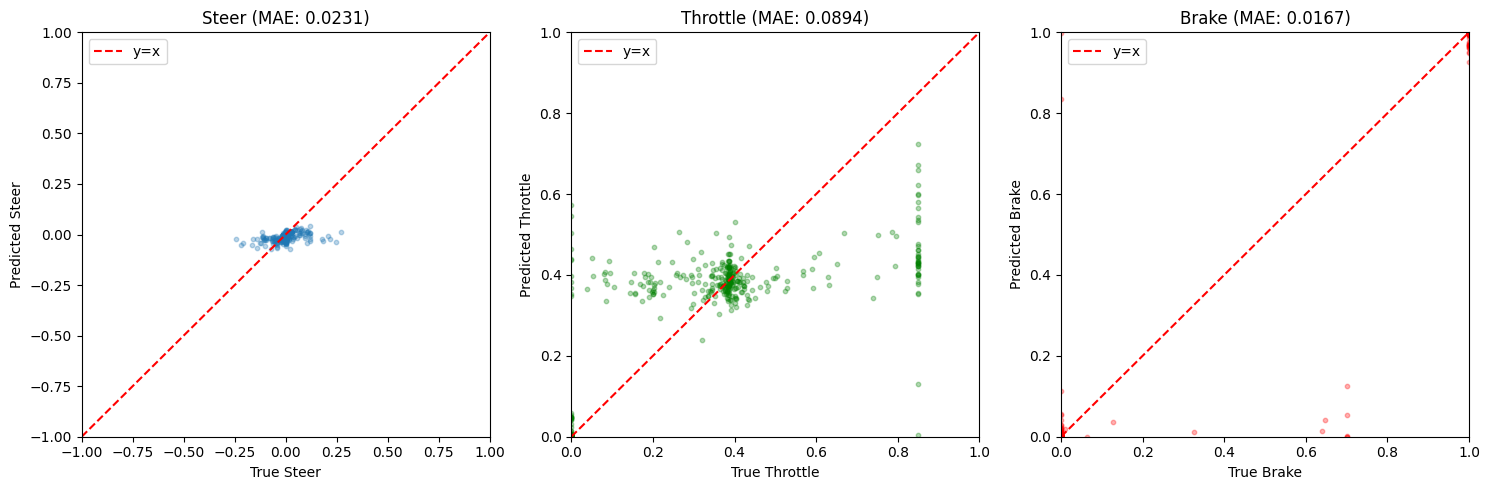

In [8]:
# Cell 8: 예측 vs 실제 시각화

if len(predictions) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Steer
    axes[0].scatter(targets[:, 0], predictions[:, 0], alpha=0.3, s=10)
    axes[0].plot([-1, 1], [-1, 1], 'r--', label='y=x')
    axes[0].set_xlabel('True Steer')
    axes[0].set_ylabel('Predicted Steer')
    axes[0].set_title(f'Steer (MAE: {steer_mae:.4f})')
    axes[0].set_xlim(-1, 1)
    axes[0].set_ylim(-1, 1)
    axes[0].legend()
    
    # Throttle
    axes[1].scatter(targets[:, 1], predictions[:, 1], alpha=0.3, s=10, color='green')
    axes[1].plot([0, 1], [0, 1], 'r--', label='y=x')
    axes[1].set_xlabel('True Throttle')
    axes[1].set_ylabel('Predicted Throttle')
    axes[1].set_title(f'Throttle (MAE: {throttle_mae:.4f})')
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].legend()
    
    # Brake
    axes[2].scatter(targets[:, 2], predictions[:, 2], alpha=0.3, s=10, color='red')
    axes[2].plot([0, 1], [0, 1], 'r--', label='y=x')
    axes[2].set_xlabel('True Brake')
    axes[2].set_ylabel('Predicted Brake')
    axes[2].set_title(f'Brake (MAE: {brake_mae:.4f})')
    axes[2].set_xlim(0, 1)
    axes[2].set_ylim(0, 1)
    axes[2].legend()
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'checkpoints' / 'evaluation_scatter.png', dpi=150)
    plt.show()

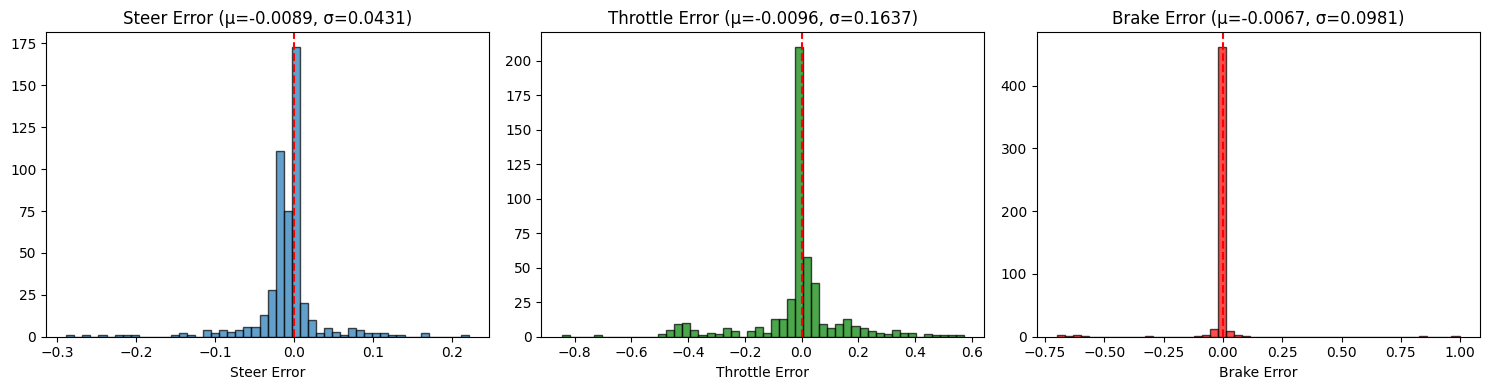

In [9]:
# Cell 9: 에러 분포 분석

if len(predictions) > 0:
    steer_error = predictions[:, 0] - targets[:, 0]
    throttle_error = predictions[:, 1] - targets[:, 1]
    brake_error = predictions[:, 2] - targets[:, 2]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].hist(steer_error, bins=50, alpha=0.7, edgecolor='black')
    axes[0].axvline(0, color='red', linestyle='--')
    axes[0].set_xlabel('Steer Error')
    axes[0].set_title(f'Steer Error (μ={np.mean(steer_error):.4f}, σ={np.std(steer_error):.4f})')
    
    axes[1].hist(throttle_error, bins=50, alpha=0.7, edgecolor='black', color='green')
    axes[1].axvline(0, color='red', linestyle='--')
    axes[1].set_xlabel('Throttle Error')
    axes[1].set_title(f'Throttle Error (μ={np.mean(throttle_error):.4f}, σ={np.std(throttle_error):.4f})')
    
    axes[2].hist(brake_error, bins=50, alpha=0.7, edgecolor='black', color='red')
    axes[2].axvline(0, color='red', linestyle='--')
    axes[2].set_xlabel('Brake Error')
    axes[2].set_title(f'Brake Error (μ={np.mean(brake_error):.4f}, σ={np.std(brake_error):.4f})')
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'checkpoints' / 'error_distribution.png', dpi=150)
    plt.show()

In [10]:
# Cell 10: CARLA 온라인 평가 (선택적)

if CARLA_AVAILABLE:
    print("=" * 50)
    print("CARLA 온라인 평가")
    print("=" * 50)
    
    evaluator = CARLAEvaluator(model, shield, transform, device)
    
    if evaluator.connect():
        NUM_EPISODES = 5
        
        for ep in range(NUM_EPISODES):
            print(f"\n에피소드 {ep + 1}/{NUM_EPISODES}")
            
            evaluator.spawn_vehicle()
            evaluator.setup_camera()
            
            try:
                metrics = evaluator.run_episode(max_frames=500)
                print(f"  - 평균 속도: {metrics.avg_speed:.1f} km/h")
                print(f"  - Shield 개입: {metrics.shield_interventions}회")
            finally:
                evaluator.cleanup()
        
        # 결과 요약
        summary = evaluator.results.get_summary()
        print("\n=== 평가 결과 요약 ===")
        for key, value in summary.items():
            if isinstance(value, float):
                print(f"  {key}: {value:.4f}")
            else:
                print(f"  {key}: {value}")
else:
    print("⚠️ CARLA를 사용할 수 없어 온라인 평가를 건너뜁니다.")


# Cell 10 마지막에 추가해야 할 코드
if CARLA_AVAILABLE and evaluator.world:
    settings = evaluator.world.get_settings()
    settings.synchronous_mode = False
    evaluator.world.apply_settings(settings)
    logger.info("동기 모드 해제 완료")

CARLA 온라인 평가


2025-12-15 01:10:58,395 - INFO - CARLA 연결 성공: Carla/Maps/Town10HD_Opt



에피소드 1/5
  - 평균 속도: 0.1 km/h
  - Shield 개입: 0회

에피소드 2/5
  - 평균 속도: 0.1 km/h
  - Shield 개입: 0회

에피소드 3/5
  - 평균 속도: 0.1 km/h
  - Shield 개입: 0회

에피소드 4/5
  - 평균 속도: 0.1 km/h
  - Shield 개입: 0회

에피소드 5/5


2025-12-15 01:12:08,766 - INFO - 동기 모드 해제 완료


  - 평균 속도: 0.1 km/h
  - Shield 개입: 323회

=== 평가 결과 요약 ===
  num_episodes: 5
  success_rate: 1.0000
  avg_collisions: 0.0000
  collision_rate: 0.0000
  avg_lane_invasions: 0.0000
  traffic_light_compliance: 1.0000
  avg_speed_kmh: 0.1031
  avg_distance_m: 0.0000
  avg_shield_interventions: 64.6000


In [11]:
# Cell 11: 평가 결과 저장

# 결과 저장
eval_results = {
    'timestamp': datetime.now().isoformat(),
    'offline_metrics': {},
    'online_metrics': {}
}

if len(predictions) > 0:
    eval_results['offline_metrics'] = {
        'num_samples': len(predictions),
        'steer_mse': float(steer_mse),
        'throttle_mse': float(throttle_mse),
        'brake_mse': float(brake_mse),
        'steer_mae': float(steer_mae),
        'throttle_mae': float(throttle_mae),
        'brake_mae': float(brake_mae)
    }

if CARLA_AVAILABLE and 'evaluator' in dir():
    eval_results['online_metrics'] = evaluator.results.get_summary()

# 저장
eval_path = PROJECT_ROOT / 'checkpoints' / 'evaluation_results.json'
with open(eval_path, 'w') as f:
    json.dump(eval_results, f, indent=2)

print(f"✅ 평가 결과 저장: {eval_path}")

✅ 평가 결과 저장: c:\git\automotive\checkpoints\evaluation_results.json


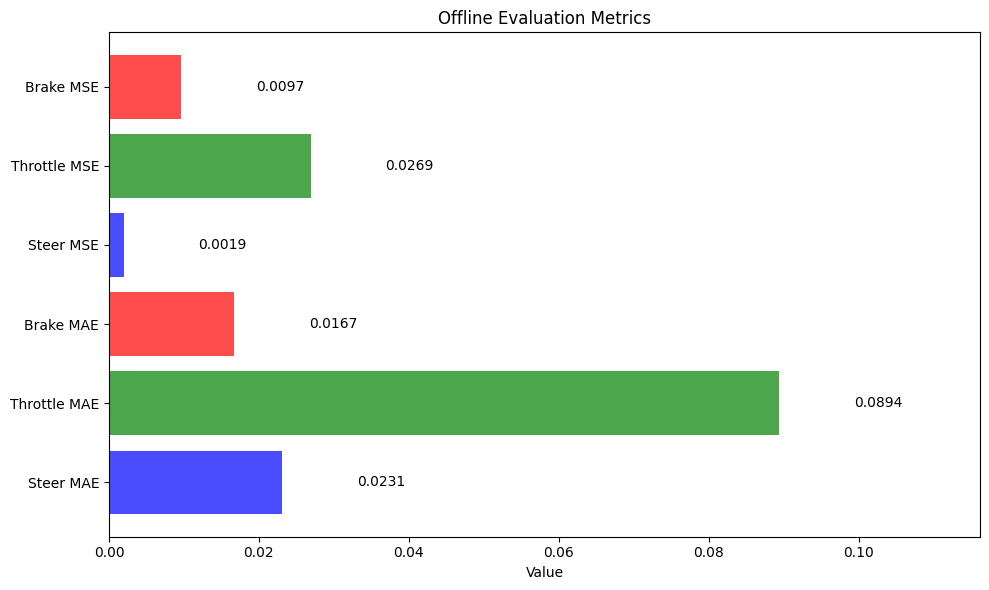

In [12]:
# Cell 12: 최종 결과 시각화

# 메트릭 요약 시각화
if len(predictions) > 0:
    metrics_dict = {
        'Steer MAE': steer_mae,
        'Throttle MAE': throttle_mae,
        'Brake MAE': brake_mae,
        'Steer MSE': steer_mse,
        'Throttle MSE': throttle_mse,
        'Brake MSE': brake_mse
    }
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    names = list(metrics_dict.keys())
    values = list(metrics_dict.values())
    colors = ['blue', 'green', 'red'] * 2
    
    bars = ax.barh(names, values, color=colors, alpha=0.7)
    
    for bar, value in zip(bars, values):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{value:.4f}', va='center')
    
    ax.set_xlabel('Value')
    ax.set_title('Offline Evaluation Metrics')
    ax.set_xlim(0, max(values) * 1.3)
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'checkpoints' / 'metrics_summary.png', dpi=150)
    plt.show()

In [13]:
# Cell 13: 평가 완료 요약

print("=" * 60)
print("                    평가 완료")
print("=" * 60)

print("\n📊 오프라인 평가 (수집 데이터)")
if len(predictions) > 0:
    print(f"   샘플 수: {len(predictions)}")
    print(f"   Steer MAE: {steer_mae:.4f}")
    print(f"   Throttle MAE: {throttle_mae:.4f}")
    print(f"   Brake MAE: {brake_mae:.4f}")
else:
    print("   데이터 없음")

print("\n🚗 CARLA 온라인 평가")
# CARLA 연결 안전 종료
if CARLA_AVAILABLE and 'evaluator' in dir() and evaluator is not None:
    try:
        evaluator.cleanup()
        if evaluator.world:
            settings = evaluator.world.get_settings()
            settings.synchronous_mode = False
            evaluator.world.apply_settings(settings)
        evaluator.client = None
        evaluator.world = None
    except:
        pass
else:
    print("   CARLA 미실행")

print("\n📁 저장된 파일")
print(f"   {PROJECT_ROOT / 'checkpoints' / 'evaluation_results.json'}")
print(f"   {PROJECT_ROOT / 'checkpoints' / 'evaluation_scatter.png'}")
print(f"   {PROJECT_ROOT / 'checkpoints' / 'error_distribution.png'}")
print(f"   {PROJECT_ROOT / 'checkpoints' / 'metrics_summary.png'}")

print("\n" + "=" * 60)
print("              자율주행 AI 파이프라인 완료!")
print("=" * 60)

                    평가 완료

📊 오프라인 평가 (수집 데이터)
   샘플 수: 500
   Steer MAE: 0.0231
   Throttle MAE: 0.0894
   Brake MAE: 0.0167

🚗 CARLA 온라인 평가

📁 저장된 파일
   c:\git\automotive\checkpoints\evaluation_results.json
   c:\git\automotive\checkpoints\evaluation_scatter.png
   c:\git\automotive\checkpoints\error_distribution.png
   c:\git\automotive\checkpoints\metrics_summary.png

              자율주행 AI 파이프라인 완료!


## 평가 요약

### 평가 방법

| 유형 | 설명 | 메트릭 |
|------|------|--------|
| **오프라인** | 수집 데이터로 예측 정확도 평가 | MSE, MAE |
| **온라인** | CARLA 환경에서 실제 주행 평가 | 성공률, 충돌률, 지침 준수율 |

### CARLA Benchmark 참고
- **Success Rate**: 목표 도달 비율
- **Collision Rate**: 충돌 발생 비율
- **Infraction Score**: 규칙 위반 점수

### 참고 논문

| 논문 | 핵심 아이디어 |
|------|---------------|
| CARLA Benchmark (Dosovitskiy et al., 2017) | 자율주행 평가 프로토콜, 다양한 시나리오 |
| NoCrash Benchmark (Codevilla et al., 2019) | 더 엄격한 평가, 복잡한 시나리오 |
| CARLA Leaderboard | 최신 자율주행 알고리즘 비교 |